In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
from scipy.spatial import ConvexHull
import meshio
import scipy
from pygsp.graphs import Graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
class Equiangulartovtk(Graph):
     
    def make_coords(self):
        alpha = np.arange(2 * 16) * np.pi / 16
        l = 1
        alpha1 = np.linspace(0, l, 14, endpoint=False)
        alpha2 = np.linspace(l, np.pi-l, 5, endpoint=False)
        alpha3 = np.linspace(np.pi-l, np.pi, 14, endpoint=False)        
        beta = np.concatenate([alpha1, alpha2, alpha3])
      
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        return coords[2*16-1:]

    def __init__(self):
        from pyevtk.hl import unstructuredGridToVTK
        from pyevtk.vtk import VtkTriangle, VtkQuad
        
        self.coords = self.make_coords()
        self.x = self.coords[:,0]
        self.y = self.coords[:,1]
        self.z = self.coords[:,2]
        
        
        
                
       
        tri = ConvexHull(self.coords)
        
        
        self.simplices = tri.simplices
        self.conn = self.simplices.flatten()
        self.offset = np.arange(3,len(self.conn)+1, 3)
        self.ctype = np.ones(len(self.offset))*VtkTriangle.tid
        distances_squared = scipy.spatial.distance.cdist(self.coords, self.coords)**2
        W = np.exp(-distances_squared/0.1)
        W = W-np.diag(np.diag(W))
        super(Equiangulartovtk, self).__init__(W=W, coords=self.coords)

    def save(self, title='unstructured', pointData=None):
        from pyevtk.hl import unstructuredGridToVTK
        if pointData is not None:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': pointData})
        else:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': self.x})

<IPython.core.display.Javascript object>


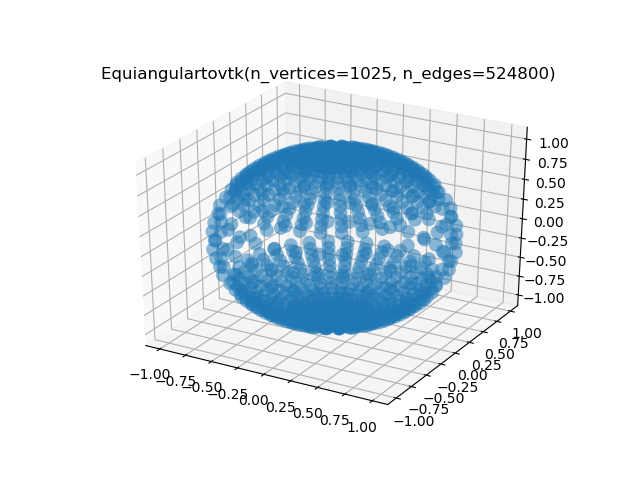

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1a25346550>)

In [60]:
sphere = Equiangulartovtk()
sphere.plot()

In [61]:
import meshio

cells = {"triangle": sphere.simplices}
meshio.write_points_cells(
    "imbalanced.xml",
    sphere.coords,
    cells,
)

In [41]:
L = sphere.L

In [54]:
from scipy.sparse.linalg import eigsh

eig_values, eig_vectors = eigsh(L, 20, which='SM')

eig_vectors = eig_vectors[:, np.argsort(eig_values)]

In [57]:
for i in range(20):
    sphere.save("graph_eigenvectors_{}".format(i), pointData=eig_vectors[:,i])